In [92]:
#!nvidia-smi

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [2]:
configs = {
    "batch_size" : 128,
    "max_file_count" : 2179,
    "train_file" : 10,
    "validation_file" : 3,
    "test_file" : 3,
    "input_size" :64,
    "output_size" : 1,
    "init_learning_rate" : 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 5,
    "scheduler_min_lr": 3e-6,
    "epoch" : 50,
    "model_name" : "LSTM9",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [95]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/66239 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6577 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/19578 [00:00<?, ?it/s]

In [3]:
torch.set_default_dtype(torch.float32)

class LSTMBlock(nn.Module) :
    def __init__(self, input_size, output_size) :
        super().__init__()
        self.LSTM = nn.LSTM(input_size,output_size,1,batch_first=True,bias=False)
        self.Dropout = nn.Dropout(p=0.2)
    
    def forward(self, input) :
        h1,_ = self.LSTM(input)
        output = self.Dropout(h1)
        return output

class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 50
        self.batch_size = configs["batch_size"]
        self.layer1 = LSTMBlock(1,self.hidden_size)
        self.layer2 = LSTMBlock(self.hidden_size,self.hidden_size)
        self.layer3 = LSTMBlock(self.hidden_size,self.hidden_size)
        self.layer4 = nn.Linear(self.hidden_size,1)

    def forward(self, input) :
        input = torch.multiply(input,25)
        h1 = self.layer1(input)
        h2 = self.layer2(h1)
        h3 = self.layer3(h2)
        output = self.layer4(h3[:,-1,:])
        output = torch.multiply(output,0.04)
        return output


In [113]:
# temp const
# scaler = torch.tensor((np.array([0.04,1,1,1,1,0.02]).reshape(-1,1) @ np.array([1] * configs["input_size"]).reshape(1,-1)).T)
# scaler = scaler.type(torch.float32)

In [117]:
model = StockLSTM()
model = model.to(device)

# summary(model,input_size=(configs["batch_size"],configs["input_size"],1))

In [118]:
try_input = torch.rand(configs["batch_size"],configs["input_size"],1)
try_input = try_input.to(device=device)

daa_out = model(try_input)

In [119]:
# L1loss_function = torch.nn.L1Loss()

# def loss_fn(target, input) :
#     penalty = 0.005
#     return torch.mul(torch.mean(torch.lt(torch.mul(target,input),0).type(torch.float32)),penalty) + L1loss_function(target,input)

loss_fn = torch.nn.L1Loss()

In [120]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)


In [121]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)
        

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        
        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015983500208064366
val loss :  0.016948313543609546


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015979428085673247
val loss :  0.016947103846891253


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015982878812349166
val loss :  0.01695442716499754


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015979908057263327
val loss :  0.01695035051043127


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015982765871923366
val loss :  0.01693064814396933


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015975500320082592
val loss :  0.016927243831257027


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01597716396123286
val loss :  0.01696387917606854


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015982183856561753
val loss :  0.01692615695955122


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01598403992300684
val loss :  0.016928427341375864


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01597873532759094
val loss :  0.01691826471291921


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015978322099584445
val loss :  0.016920089064275518


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015974120860216812
val loss :  0.016931041454275448


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01597366574431123
val loss :  0.016930354466917468


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015979365393432934
val loss :  0.016899670675104738


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01597120418308782
val loss :  0.01691184397421631


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015982545141267592
val loss :  0.01690964017282514


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01598280386339938
val loss :  0.016896380659411934


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015979323474910087
val loss :  0.016924403753935124


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01598093857920262
val loss :  0.016946401629669993


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01597862425161169
val loss :  0.016946938546264872


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015983039990600696
val loss :  0.016917467026003434


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01597763123296965
val loss :  0.016906312027690457


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01598151289899356
val loss :  0.016957548958267652


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015979477764617084
val loss :  0.016923762711824154


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015978048081785382
val loss :  0.016946499035054564


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01598119419932769
val loss :  0.016944538053198187


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015977308721546395
val loss :  0.0168980895998139


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015975690207208147
val loss :  0.01694391781062472


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01597533749535363
val loss :  0.016931004329201055


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01597995511337221
val loss :  0.01691412816152853


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015975946528076896
val loss :  0.016901307794101098


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015972557333541217
val loss :  0.016917620529877206


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01597481232489562
val loss :  0.01692894000706135


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015976768397731524
val loss :  0.016923811633651163


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015980938523359293
val loss :  0.016933961406204047


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015972055012010745
val loss :  0.016928111604761844


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01597567599237945
val loss :  0.016876799711848006


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015975617409127132
val loss :  0.016924904586345543


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01597561336498945
val loss :  0.016897517840797995


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.01598155708007183
val loss :  0.016909928042806832


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015981539147158424
val loss :  0.01689208784670222


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015980361009690355
val loss :  0.016882781633267216


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015975135603714267
val loss :  0.016917019297240998


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015977598642083733
val loss :  0.016877360349776698


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015972159312933512
val loss :  0.016917707453317502


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015976846266746867
val loss :  0.01691144498466861


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015974272343346297
val loss :  0.01692613090078036


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015975385407126386
val loss :  0.01690037302015459


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015978048297953098
val loss :  0.016919800116881437


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

train loss :  0.015970148846896175
val loss :  0.01690914180568036


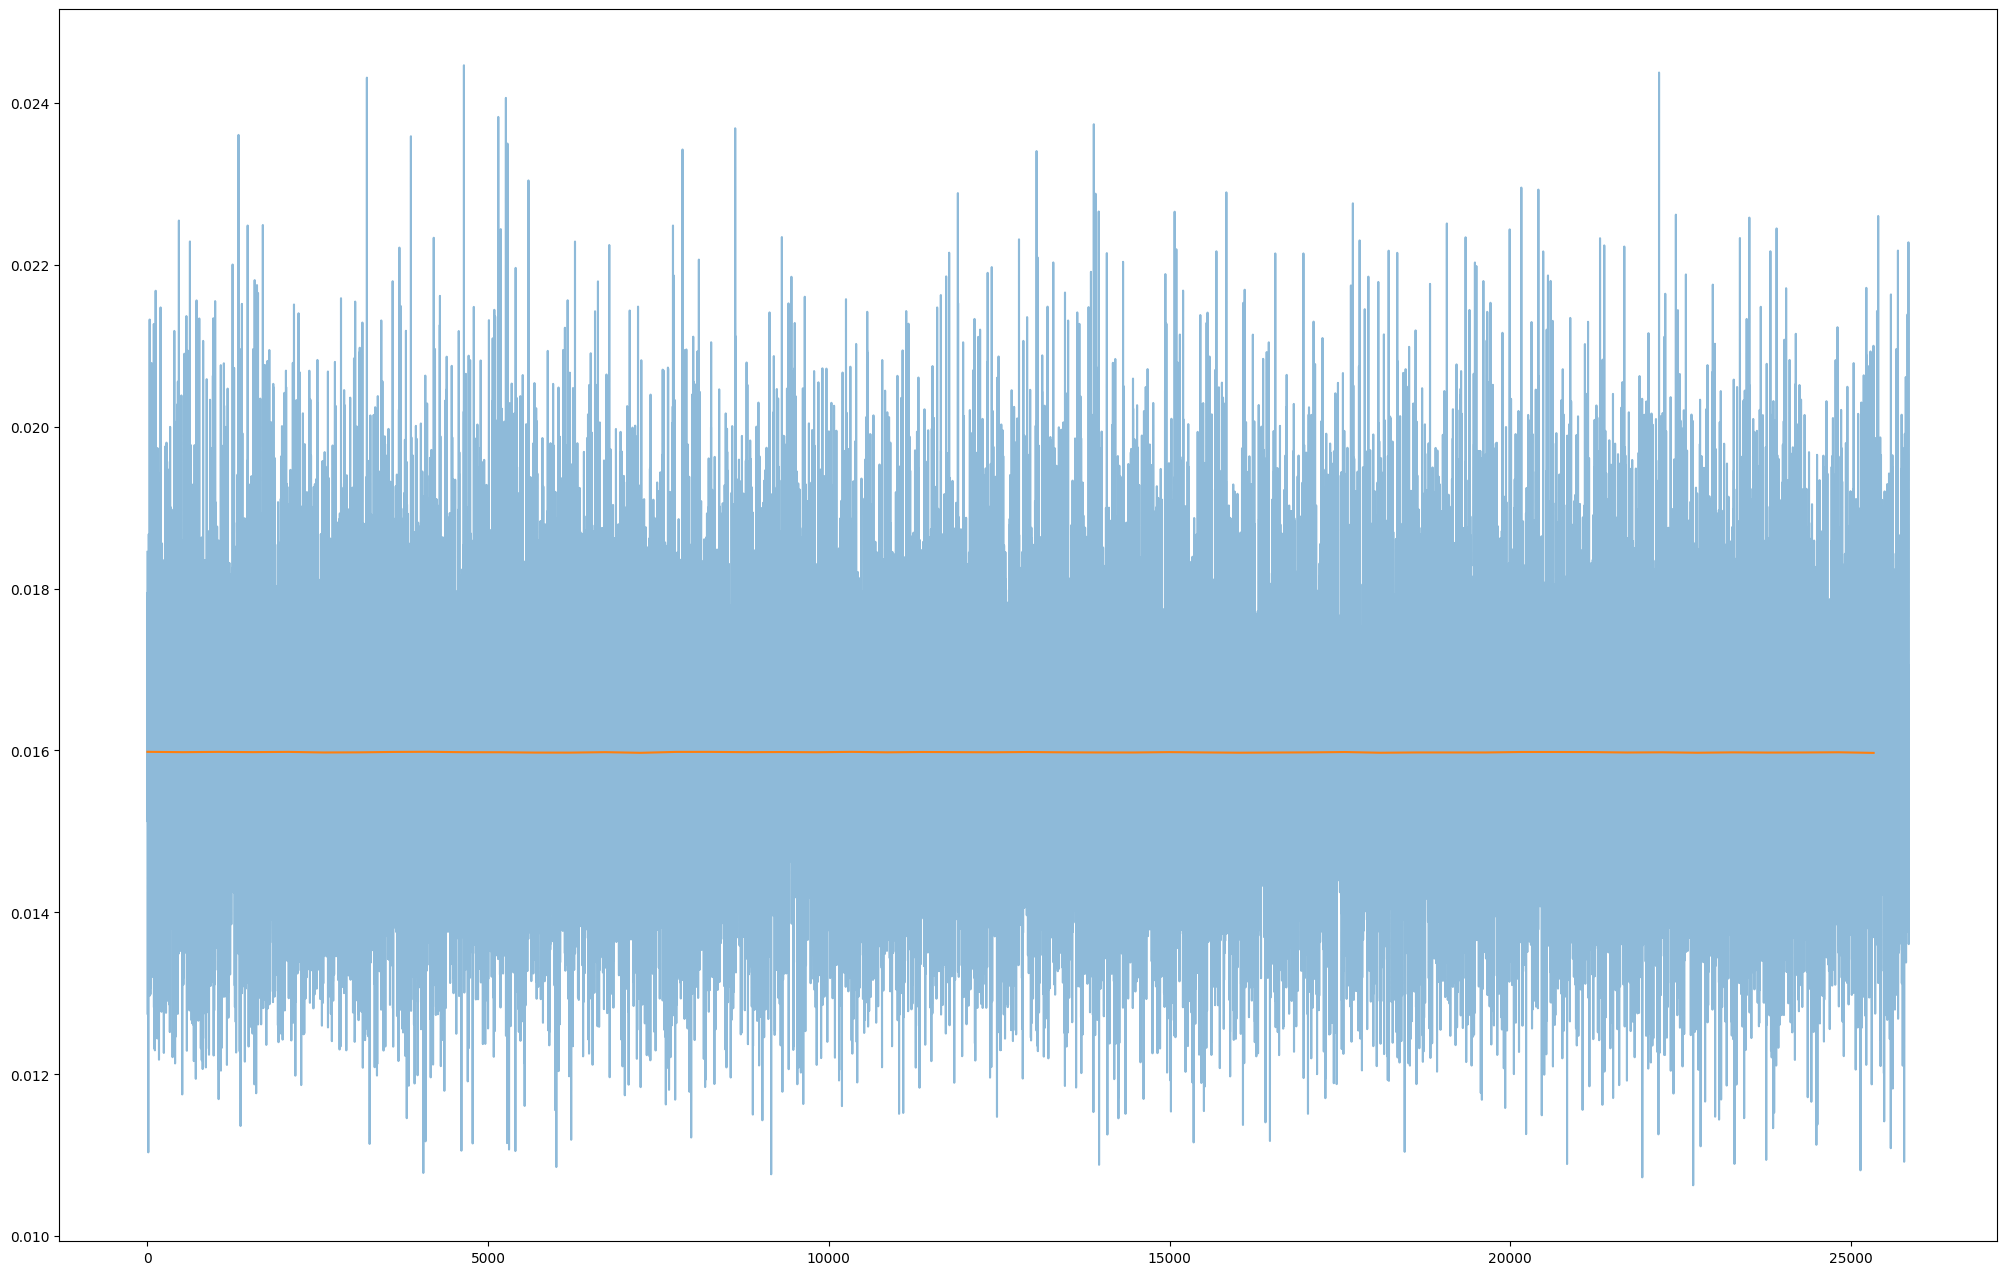

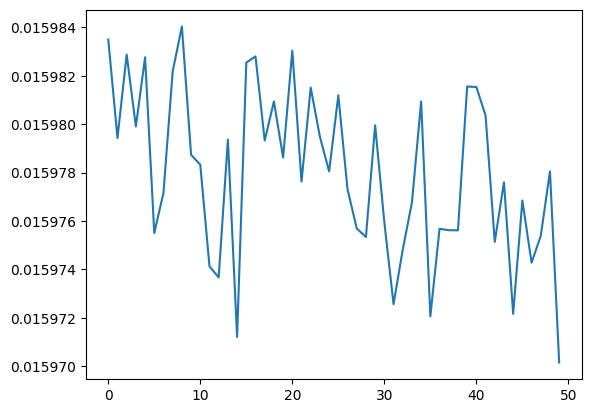

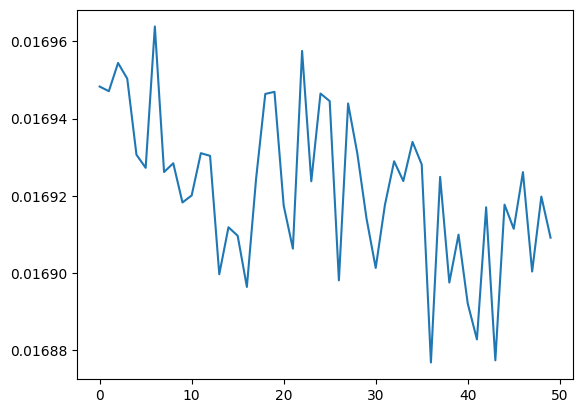

In [122]:
plt.figure(figsize=(25, 16))
plt.plot(train_losses,alpha=0.5)
plt.plot(list(range(0,len(train_losses),int(len(train_losses) / len(avarage_train_losses)))),avarage_train_losses)
plt.show()
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [123]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [4]:
best_model = StockLSTM()
best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockLSTM(
  (layer1): LSTMBlock(
    (LSTM): LSTM(1, 50, bias=False, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
  )
  (layer2): LSTMBlock(
    (LSTM): LSTM(50, 50, bias=False, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
  )
  (layer3): LSTMBlock(
    (LSTM): LSTM(50, 50, bias=False, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
  )
  (layer4): Linear(in_features=50, out_features=1, bias=True)
)

In [125]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/153 [00:00<?, ?it/s]

0.014046256068946892


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

0.0787809 -> -0.00024116367 **
0.07536981 -> -0.0004954839 **
0.012798197 -> -0.0007511306 **
-0.06816741 -> -0.0006303516 
0.028067779 -> 7.7661105e-05 
0.049305767 -> 7.770072e-05 
-0.035710223 -> -0.00025281476 
0.025347505 -> 1.649227e-05 
0.38677296 -> -2.8492734e-05 **
-0.113077186 -> -0.0010199026 
0.06805346 -> -0.0009294075 **
0.006557376 -> -0.0008985191 **
-0.07461086 -> -0.000669236 
-0.07872321 -> 0.000113425995 **
-0.07821893 -> 0.001251348 **
-0.060495876 -> 0.0026677924 **
0.032825094 -> 0.0040675546 
0.025608858 -> 0.0031351738 
-0.06282008 -> 0.0019497531 **
0.010929129 -> 0.0022579564 
0.037861113 -> 0.0019181208 
0.0020908893 -> 0.0010189972 
0.0026075197 -> 0.0005968416 
-0.049102634 -> 0.0004194841 **
0.041784283 -> 0.00086512894 
-0.061674483 -> 0.00041275367 **
-0.06453846 -> 0.000831846 **
-0.009569451 -> 0.001779271 **
-0.059423465 -> 0.0019372385 **
-0.04700608 -> 0.0026809478 **
0.036105033 -> 0.0035700484 
0.07989396 -> 0.0025891496 
0.15006064 -> 0.0008849

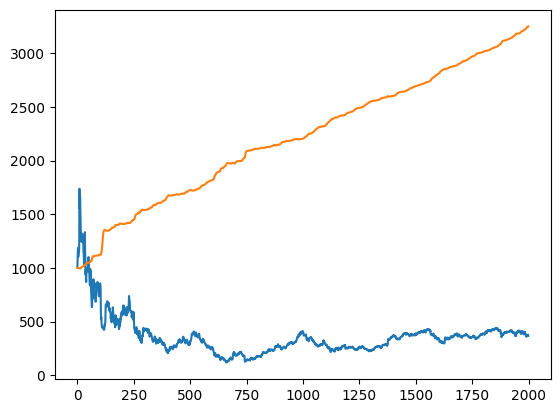

In [10]:
plot_dataset = StockDatasetLogReturn(["./data/A.csv"],configs["input_size"],1)

real = [1000]
predict = [1000]
price = 1000

feed_queue = list(range(plot_dataset.__len__()))
rd.shuffle(feed_queue)
predict_output = []
real_output = []
with torch.no_grad() : 
    for i in tqdm(range(0,plot_dataset.__len__(),configs["batch_size"])) :
        close_price_input = []
        close_price_target = []
        for j in range(configs["batch_size"]) :
            input,target = plot_dataset.__getitem__(i + j)
            close_price_input.append(input[None,4,:,None])
            close_price_target.append(target[4].numpy())
        close_price_input = torch.cat(close_price_input).to(device)

        output = best_model(close_price_input)
        output = output.to(torch.device("cpu")).numpy()

        for j in range(configs["batch_size"]) :
            real_output.append(math.exp(close_price_target[j][0]))
            predict_output.append(math.exp(output[j][0]))
            print(close_price_target[j][0],"->",output[j][0],"**" if close_price_target[j][0] * output[j][0] < 0 else "")

for i in range(len(predict_output)) :
    predict.append(predict[-1] * predict_output[i])
    real.append(real[-1] * real_output[i])

plt.plot(real[0:2000])
plt.plot(predict[0:2000])
plt.show()

In [7]:
print(np.mean((np.log(np.array(real_output)) * np.log(np.array(predict_output))) > 0))

0.5198567708333334


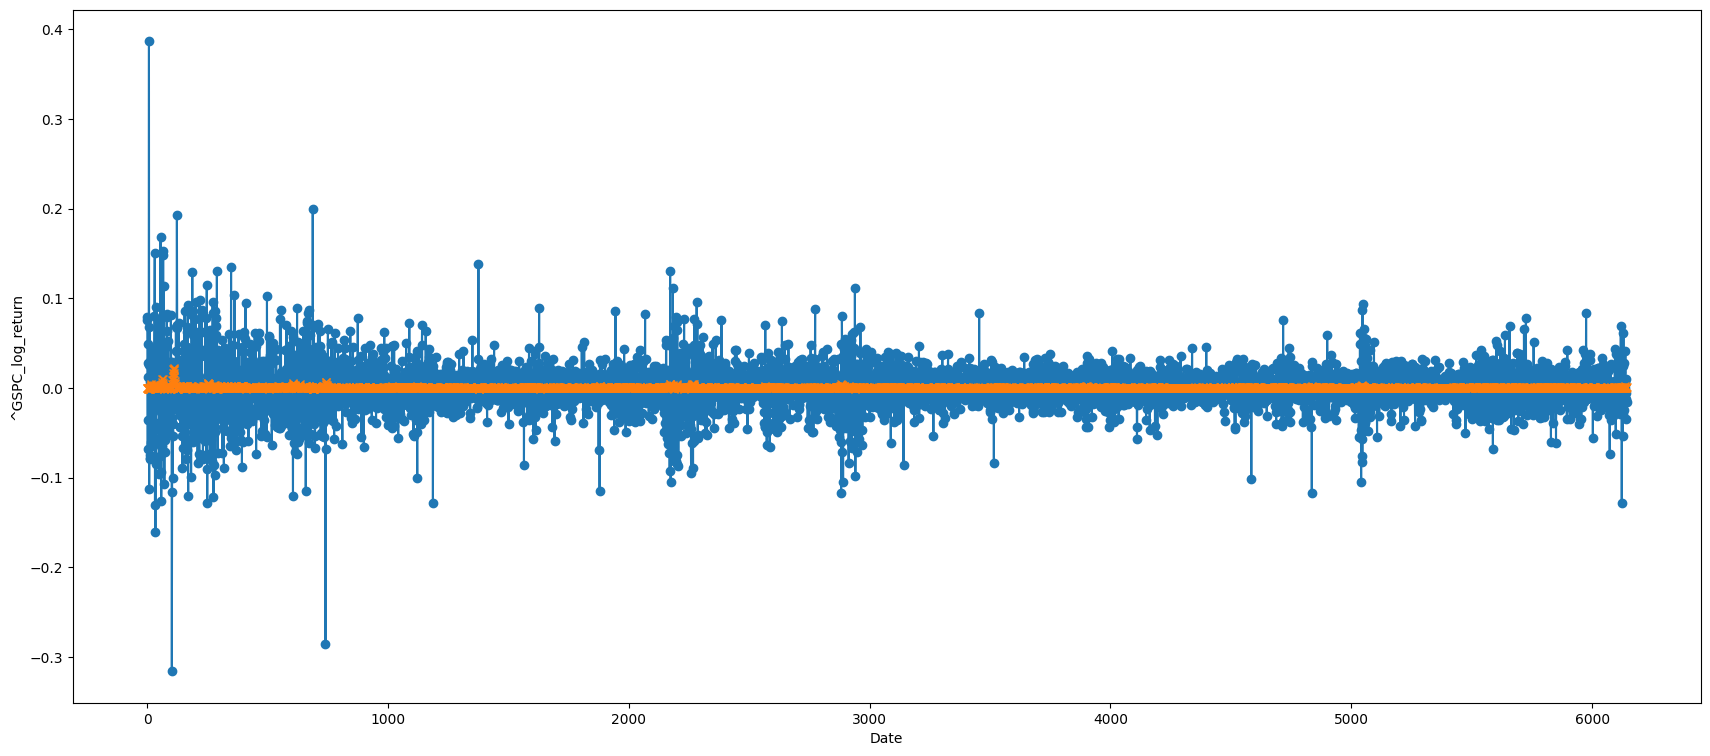

In [127]:
log_real_output = list(map(math.log,real_output))
log_predict_output = list(map(math.log,predict_output))
plt.figure(figsize=(21, 9))
plt.plot(log_real_output, label="Actual", marker='o')
plt.plot(log_predict_output, label= "Predicted",marker='x')
plt.xlabel('Date')
plt.ylabel('^GSPC_log_return')
plt.show()

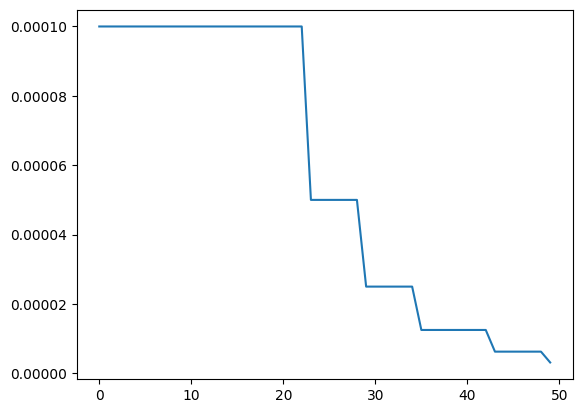

In [128]:
plt.plot(learning_rates)
plt.show()